In [10]:
# import libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dash
from dash import dcc, html, Input, Output
import base64
import io


# file path
path = "/home/comfort/Downloads/crimes-reported-to-police2014-2018.csv"

# reading data, using pandas
data = pd.read_csv(path)

# Reading the first five rows:
data.head(5)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,"Crimes Reported to Police by Command Station, ...",NaN,NaN,NaN,NaN,NaN
1,"Kenya National Bureau of Statistics, 2019",NaN,NaN,NaN,NaN,NaN
2,https://www.knbs.or.ke/download/economic-surve...,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,geo_level,geo_code,geo_version,county,year,total


In [11]:
# Dropping columns with lot of NaN values
data = data.drop(columns=["Unnamed: 2"]) 

# Reseting the index after drop
data = data.iloc[5:, 0:].reset_index(drop = True)

# First five rows to check my work
data.head(5)

,Unnamed: 0,Unnamed: 1,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,county,30,Baringo,2014,923
1,county,30,Baringo,2015,1035
2,county,30,Baringo,2016,827
3,county,30,Baringo,2017,821
4,county,30,Baringo,2018,882


In [12]:
# changing from data type "object" to "Numbers"
data["Unnamed: 5"] = pd.to_numeric(data["Unnamed: 5"], errors="coerce")
data["Unnamed: 4"] = pd.to_numeric(data["Unnamed: 4"], errors="coerce")
data["Unnamed: 1"] = pd.to_numeric(data["Unnamed: 1"], errors="coerce")

In [13]:
# Filter the DataFrame for the specified years since some cities does not have record of all(2014-2015)
subset_data = data[data["Unnamed: 4"].isin([2014, 2015, 2016, 2017, 2018])]

# filter data against, entry "kenya", since it is not city but country
subset_data = subset_data[~(subset_data["Unnamed: 3"] == "Kenya")]

# subseting based on the year for plot
sub_year_2014 = subset_data[subset_data["Unnamed: 4"] == 2014].groupby(["Unnamed: 3"])["Unnamed: 5"].sum()
sub_year_2015 = subset_data[subset_data["Unnamed: 4"] == 2015].groupby(["Unnamed: 3"])["Unnamed: 5"].sum()
sub_year_2016 = subset_data[subset_data["Unnamed: 4"] == 2016].groupby(["Unnamed: 3"])["Unnamed: 5"].sum()
sub_year_2017 = subset_data[subset_data["Unnamed: 4"] == 2017].groupby(["Unnamed: 3"])["Unnamed: 5"].sum()
sub_year_2018 = subset_data[subset_data["Unnamed: 4"] == 2018].groupby(["Unnamed: 3"])["Unnamed: 5"].sum()


# Taking only top 10 for each year
year_2014 = sub_year_2014.sort_values(ascending = False).head(10)
year_2015 = sub_year_2015.sort_values(ascending = False).head(10)
year_2016 = sub_year_2016.sort_values(ascending = False).head(10)
year_2017= sub_year_2017.sort_values(ascending = False).head(10)
year_2018 = sub_year_2018.sort_values(ascending = False).head(10)

# This is crime report for entire 5 years period {visualized using pie-chart}
country_crime = subset_data = subset_data.groupby("Unnamed: 4")["Unnamed: 5"].sum().sort_values(ascending = False)


In [14]:
year_2015.index

Index(['Kiambu', 'Nakuru', 'Nairobi', 'Meru', 'Mombasa', 'Bungoma', 'Kakamega',
       'Murang'a', 'Kisumu', 'Kilifi'],
      dtype='object', name='Unnamed: 3')

In [15]:
# # Plotting a pie chart
# plt.figure(figsize=(8, 8))
# plt.pie(country_crime, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(country_crime))})")
# plt.title('Kenya Crime Report over 5 years')

# # Creating legend for years
# plt.legend(country_crime.index, title="Years", loc="best")
# plt.show()

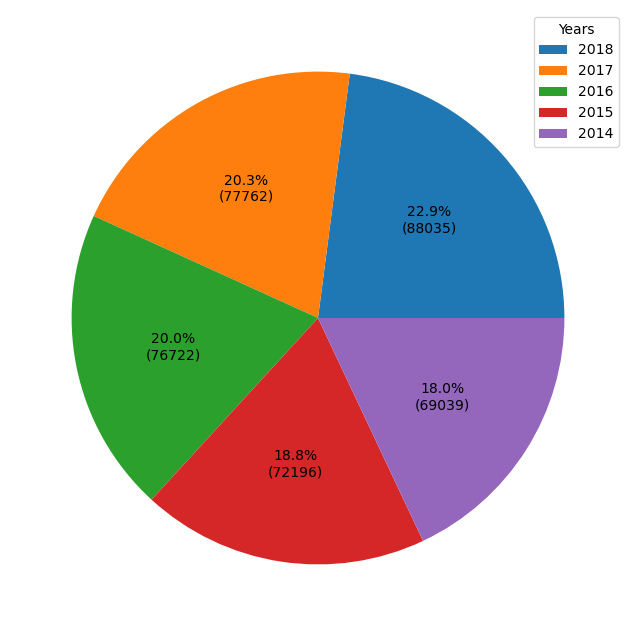

In [16]:

# Sample data
# Assuming year_2014, year_2015, ..., year_2018 are pandas Series objects with reported crime data for each year
# Replace this with your actual data
year_2014 = pd.Series(data= year_2014.values, index=year_2014.index)
year_2015 = pd.Series(data=year_2015.values, index=year_2015.index)
year_2016 = pd.Series(data=year_2016.values, index=year_2016.index)
year_2017 = pd.Series(data=year_2017.values, index=year_2017.index)
year_2018 = pd.Series(data=year_2018.values, index=year_2018.index)

# Sample data for pie chart
country_crime = pd.Series(data=country_crime.values, index=country_crime.index)

# Create Dash app
app = dash.Dash(__name__)

# Define dropdown options
years = ['2014', '2015', '2016', '2017', '2018']

# Define layout
app.layout = html.Div(style={'backgroundColor': '#e0f0ff', 'padding': '20px'}, children=[
    html.H1(children='Kenya Reported Crimes', style={'textAlign': 'center', 'color': '#333333'}),
    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': year, 'value': year} for year in years],
        value='2014',
        style={'width': '50%', 'margin': '0 auto', 'marginBottom': '20px', 'color': '#333333'}
    ),
    html.Div(children=[
        dcc.Graph(id='crime-bar-chart', style={'display': 'inline-block', 'width': '48%'}),
        dcc.Graph(id='crime-pie-chart', style={'display': 'inline-block', 'width': '48%', 'margin-left': '2%'})
    ])
])

# Define callback to update the charts based on selected year
@app.callback(
    [Output('crime-bar-chart', 'figure'),
     Output('crime-pie-chart', 'figure')],
    [Input('year-dropdown', 'value')]
)
def update_charts(selected_year):
    # Get the corresponding pandas Series for the selected year
    year_data = globals()['year_' + selected_year]
    
    # Create bar chart figure
    bar_chart_figure = {
        'data': [
            {'x': year_data.index, 'y': year_data.values, 'type': 'bar', 'name': selected_year}
        ],
        'layout': {
            'title': f'Reported Crimes ({selected_year})',
            'xaxis': {'title': 'Cities'},
            'yaxis': {'title': 'Number of reported crimes'},
            'plot_bgcolor': '#e0f0ff',  # Set background color
            'paper_bgcolor': '#e0f0ff',  # Set paper color
            'font': {'color': '#333333'}  # Set font color
        }
    }
    
    # Create pie chart figure
    pie_chart_figure = {
        'data': [
            {'labels': year_data.index, 'values': year_data.values, 'type': 'pie',
             'hoverinfo': 'label+percent+value', 'textinfo': 'label+value+percent'}
        ],
        'layout': {
            'title': 'Kenya Crime Report (2014-2018)'
        }
    }
    
    return bar_chart_figure, pie_chart_figure

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(country_crime, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(country_crime))})")

# Creating legend for years
plt.legend(country_crime.index, title="Years", loc="best")
plt.show()